## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.regularizers import l1_l2
from keras.layers import Dropout
 
def build_mlp1(input_shape, output_units=10, num_neurons=[256, 128, 64], l1_ratio=0.0001, l2_ratio=0.001, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

from keras.layers import BatchNormalization

def build_mlp2(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 40
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.2, 0.4]
L1_EXP = [1e-4, 1e-8]
L2_EXP = [1e-5, 1e-7]

In [10]:
results = {}
for l1r, l2r, drp in itertools.product(L1_EXP, L2_EXP, Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f, drop = %.2f" % (l1r, l2r, drp))
    model = build_mlp1(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r, drp_ratio=drp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s-drp-%s" % (str(l1r), str(l2r), str(drp))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.000100, L2 = 0.000010, drop = 0.20


W0907 17:56:53.122096  7312 deprecation.py:506] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0907 17:57:27.993828  7312 deprecation_wrapper.py:119] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

W0907 17:57:29.297774  7312 deprecation.py:323] From C:\Users\Hsin-PC\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 497s 10ms/step - loss: 4.1436 - acc: 0.1710 - val_loss: 3.9467 - val_acc: 0.2993
Epoch 2/40
50000/50000 [==============================] - 9s 186us/step - loss: 3.9267 - acc: 0.2616 - val_loss: 3.7828 - val_acc: 0.3367
Epoch 3/40
50000/50000 [==============================] - 9s 189us/step - loss: 3.8136 - acc: 0.2940 - val_loss: 3.6950 - val_acc: 0.3559
Epoch 4/40
50000/50000 [==============================] - 9s 184us/step - loss: 3.7282 - acc: 0.3171 - val_loss: 3.6061 - val_acc: 0.3718
Epoch 5/40
50000/50000 [==============================] - 9s 184us/step - loss: 3.6527 - acc: 0.3391 - val_loss: 3.5352 - val_acc: 0.3906
Epoch 6/40
50000/50000 [==============================] - 9s 184us/step - loss: 3.5917 - acc: 0.3503 - val_loss: 3.4720 - val_acc: 0.3986
Epoch 7/40
50000/50000 [==============================] - 9s 184us/step - loss: 3.5321 - acc: 0.3645 - val_loss: 3.4153 -

Epoch 9/40
50000/50000 [==============================] - 9s 180us/step - loss: 3.6072 - acc: 0.3003 - val_loss: 3.4664 - val_acc: 0.3763
Epoch 10/40
50000/50000 [==============================] - 9s 179us/step - loss: 3.5595 - acc: 0.3097 - val_loss: 3.4170 - val_acc: 0.3849
Epoch 11/40
50000/50000 [==============================] - 9s 179us/step - loss: 3.5140 - acc: 0.3204 - val_loss: 3.3639 - val_acc: 0.3908
Epoch 12/40
50000/50000 [==============================] - 9s 180us/step - loss: 3.4684 - acc: 0.3259 - val_loss: 3.3170 - val_acc: 0.3928
Epoch 13/40
50000/50000 [==============================] - 9s 180us/step - loss: 3.4250 - acc: 0.3290 - val_loss: 3.2802 - val_acc: 0.3949
Epoch 14/40
50000/50000 [==============================] - 9s 183us/step - loss: 3.3844 - acc: 0.3348 - val_loss: 3.2409 - val_acc: 0.4023
Epoch 15/40
50000/50000 [==============================] - 9s 180us/step - loss: 3.3471 - acc: 0.3421 - val_loss: 3.1936 - val_acc: 0.4067
Epoch 16/40
50000/50000 [===

50000/50000 [==============================] - 9s 185us/step - loss: 3.0786 - acc: 0.4268 - val_loss: 2.9728 - val_acc: 0.4657
Epoch 18/40
50000/50000 [==============================] - 9s 185us/step - loss: 3.0392 - acc: 0.4283 - val_loss: 2.9319 - val_acc: 0.4741
Epoch 19/40
50000/50000 [==============================] - 9s 184us/step - loss: 2.9972 - acc: 0.4376 - val_loss: 2.9000 - val_acc: 0.4721
Epoch 20/40
50000/50000 [==============================] - 9s 185us/step - loss: 2.9640 - acc: 0.4409 - val_loss: 2.8664 - val_acc: 0.4782
Epoch 21/40
50000/50000 [==============================] - 9s 184us/step - loss: 2.9277 - acc: 0.4432 - val_loss: 2.8306 - val_acc: 0.4787
Epoch 22/40
50000/50000 [==============================] - 9s 186us/step - loss: 2.8945 - acc: 0.4469 - val_loss: 2.8103 - val_acc: 0.4721
Epoch 23/40
50000/50000 [==============================] - 9s 186us/step - loss: 2.8591 - acc: 0.4524 - val_loss: 2.7679 - val_acc: 0.4824
Epoch 24/40
50000/50000 [==============

50000/50000 [==============================] - 9s 186us/step - loss: 2.9896 - acc: 0.3811 - val_loss: 2.8382 - val_acc: 0.4471
Epoch 26/40
50000/50000 [==============================] - 9s 187us/step - loss: 2.9569 - acc: 0.3793 - val_loss: 2.8069 - val_acc: 0.4433
Epoch 27/40
50000/50000 [==============================] - 9s 186us/step - loss: 2.9300 - acc: 0.3852 - val_loss: 2.7882 - val_acc: 0.4443
Epoch 28/40
50000/50000 [==============================] - 9s 187us/step - loss: 2.9060 - acc: 0.3855 - val_loss: 2.7468 - val_acc: 0.4514
Epoch 29/40
50000/50000 [==============================] - 9s 185us/step - loss: 2.8725 - acc: 0.3902 - val_loss: 2.7202 - val_acc: 0.4561
Epoch 30/40
50000/50000 [==============================] - 9s 186us/step - loss: 2.8422 - acc: 0.3933 - val_loss: 2.6936 - val_acc: 0.4516
Epoch 31/40
50000/50000 [==============================] - 9s 187us/step - loss: 2.8119 - acc: 0.3955 - val_loss: 2.6772 - val_acc: 0.4464
Epoch 32/40
50000/50000 [==============

50000/50000 [==============================] - 9s 180us/step - loss: 1.4530 - acc: 0.4859 - val_loss: 1.4098 - val_acc: 0.4959
Epoch 34/40
50000/50000 [==============================] - 9s 180us/step - loss: 1.4487 - acc: 0.4847 - val_loss: 1.4037 - val_acc: 0.5023
Epoch 35/40
50000/50000 [==============================] - 9s 180us/step - loss: 1.4413 - acc: 0.4902 - val_loss: 1.4015 - val_acc: 0.5005
Epoch 36/40
50000/50000 [==============================] - 9s 180us/step - loss: 1.4359 - acc: 0.4916 - val_loss: 1.3954 - val_acc: 0.5026
Epoch 37/40
50000/50000 [==============================] - 10s 190us/step - loss: 1.4215 - acc: 0.4945 - val_loss: 1.3863 - val_acc: 0.5081
Epoch 38/40
50000/50000 [==============================] - 10s 194us/step - loss: 1.4226 - acc: 0.4941 - val_loss: 1.3794 - val_acc: 0.5059
Epoch 39/40
50000/50000 [==============================] - 9s 183us/step - loss: 1.4149 - acc: 0.4970 - val_loss: 1.3868 - val_acc: 0.5078
Epoch 40/40
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 10s 205us/step - loss: 2.2148 - acc: 0.1638 - val_loss: 2.0553 - val_acc: 0.2632
Epoch 2/40
50000/50000 [==============================] - 9s 183us/step - loss: 2.0471 - acc: 0.2457 - val_loss: 1.9231 - val_acc: 0.3229
Epoch 3/40
50000/50000 [==============================] - 9s 183us/step - loss: 1.9615 - acc: 0.2823 - val_loss: 1.8551 - val_acc: 0.3468
Epoch 4/40
50000/50000 [==============================] - 9s 183us/step - loss: 1.9062 - acc: 0.3084 - val_loss: 1.7955 - val_acc: 0.3671
Epoch 5/40
50000/50000 [==============================] - 9s 185us/step - loss: 1.8588 - acc: 0.3274 - val_loss: 1.7481 - val_acc: 0.3857
Epoch 6/40
50000/50000 [==============================] - 9s 187us/step - loss: 1.8190 - acc: 0.3448 - val_loss: 1.7146 - val_acc: 0.3910
Epoch 7/40
50000/50000 [==============================] - 9s 184us/step - loss: 1.7866 - acc: 0.3556 - val_loss: 1.6764 -

50000/50000 [==============================] - 9s 187us/step - loss: 1.9249 - acc: 0.2909 - val_loss: 1.8064 - val_acc: 0.3633
Epoch 9/40
50000/50000 [==============================] - 9s 179us/step - loss: 1.9082 - acc: 0.2994 - val_loss: 1.7845 - val_acc: 0.3757
Epoch 10/40
50000/50000 [==============================] - 9s 180us/step - loss: 1.8915 - acc: 0.3098 - val_loss: 1.7725 - val_acc: 0.3761
Epoch 11/40
50000/50000 [==============================] - 9s 180us/step - loss: 1.8771 - acc: 0.3164 - val_loss: 1.7490 - val_acc: 0.3896
Epoch 12/40
50000/50000 [==============================] - 9s 182us/step - loss: 1.8554 - acc: 0.3239 - val_loss: 1.7348 - val_acc: 0.3885
Epoch 13/40
50000/50000 [==============================] - 9s 181us/step - loss: 1.8475 - acc: 0.3286 - val_loss: 1.7137 - val_acc: 0.3975
Epoch 14/40
50000/50000 [==============================] - 9s 183us/step - loss: 1.8326 - acc: 0.3355 - val_loss: 1.6972 - val_acc: 0.4030
Epoch 15/40
50000/50000 [===============

In [12]:
#Batch Normalization
keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment BN with Batch_Size = %.3f" % BATCH_SIZE)
model = build_mlp2(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
    
exp_name_tag = "exp-BN-Batch-Size = %s" % str(BATCH_SIZE)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Experiment BN with Batch_Size = 256.000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 

NameError: name 'Batch_Size' is not defined

In [13]:
exp_name_tag = "exp-BN-Batch-Size = %s" % str(BATCH_SIZE)
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

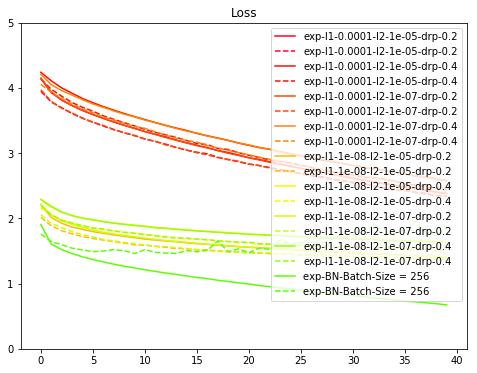

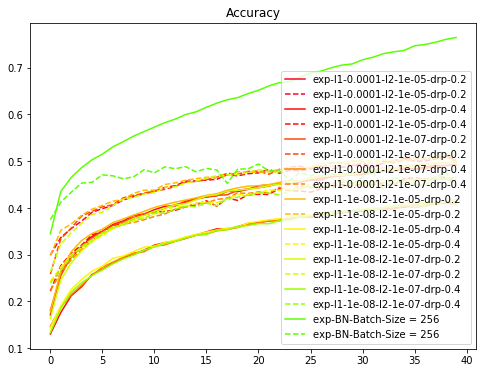

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()